In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set("talk", style="ticks")

from astropy.io import fits

from tqdm import tqdm

from pyFIT3D.modelling.stellar import SSPModels
from pyFIT3D.common.auto_ssp_tools import auto_ssp_elines_single_main
from lvmdap.modelling.synthesis import StellarSynthesis
from lvmdap.analysis.plotting import *

import warnings
warnings.filterwarnings("ignore")

import contextlib
import sys

class DummyFile(object):
    def write(self, x): pass

@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = DummyFile()
    yield
    sys.stdout = save_stdout

In [2]:
experiment = "manga"
obs_path = f"_data/{experiment}/obs/"
out_path = f"_data/{experiment}/out/"
fig_path = f"_data/{experiment}/figs/"
os.makedirs(obs_path, exist_ok=True)
os.makedirs(out_path, exist_ok=True)
os.makedirs(fig_path, exist_ok=True)


true_param_table = pd.DataFrame(data=os.listdir(obs_path), columns=["sed_file"])

In [3]:
# See the similar script to run the analysis with intrumental dispersion: 
#      bin/auto_ssp_elines_rnd_sigma_inst.py
#

# using the initial values:
#
# Instrumental dispersion: 2.5 AA
sigma_inst = 0.001

# Velocity dispersion of the gas in AA
sigma_gas = 3.7

# Masks:
#     File with list of ranges of wavelength to be masked in whole analysis
mask_list = os.path.abspath("../../_fitting-data/_configs/mask_elines.txt")

######################
######################
# Non linear analysis: (redshift, observed dispersion and dust attenuation)
#     wavelength range: 
#         [3850, 4700] AA for the redshift and sigma analysis
#         [3800, 7000] AA for the dust attenuation
w_min_max = [3850, 9000]
nl_w_min_max = [3850, 4700]

#     models:
#         Miles solar 3 models
ssp_nl_fit_file = os.path.abspath("../../_fitting-data/_basis_mastar_v2/stellar-basis-spectra-5.fits.gz")

#     emission lines to be masked:
elines_mask_file = os.path.abspath("../../_fitting-data/_configs/MaNGA/emission_lines_long_list.txt")

#     redshift:
#         initial value: 0.02449
#                 delta: 0.0001
#                   min: 0.02349
#                   max: 0.02549
redshift_set = [0.025,0.0001,0.023,0.12]

#     dispersion: (km/s)
#         initial value: 30
#                 delta: 20
#                   min: 1
#                   max: 150
sigma_set = [10,10,0,350]

#     dust attenuation at V band (mag):
#         initial value: 0.3
#                 delta: 0.15
#                   min: 0
#                   max: 1.6
AV_set = [0.3,0.15,0,1.6]

# SSP analysis:
#     wavelength range: 
#         [3800, 7000] AA
#
#     models:
#         GSD01 156 models
ssp_file = os.path.abspath("../../_fitting-data/_basis_mastar_v2/stellar-basis-spectra-100.fits.gz")
par_file = os.path.abspath("../../_fitting-data/_basis_mastar_v2/stellar-basis-params-100.fits.gz")

# for pyFIT3D use:
# miles_3_solar
# miuscat_12
# sigma_inst = 0.7656

# plot options
stellar_param = fits.open(par_file)

labels = {"TEFF":r"$\log{T_\text{eff}}$", "LOGG":r"$\log{g}$", "MET":r"$[\text{Fe}/\text{H}]$", "ALPHAM":r"$[\alpha/\text{Fe}]$"}
cmap = "binary_r"
color = sns.color_palette(cmap)[0]

In [4]:
import subprocess


subprocess.run(["tsp", "-S", "30"])
for idx, row in tqdm(true_param_table.iterrows(), total=len(true_param_table), desc=f"fitting {experiment}", ascii=True, unit="SED"):
    label = row.sed_file.replace(".spec_5.txt", "")
    if os.path.isfile(os.path.join(out_path,label)): continue
    subprocess.run(f"tsp lvm-dap {os.path.join(obs_path,row.sed_file)} {ssp_file} {sigma_inst} {label} --rsp-nl-file {ssp_nl_fit_file} --w-range {' '.join(map(str,w_min_max))} --w-range-nl {' '.join(map(str,nl_w_min_max))} --redshift {' '.join(map(str,redshift_set))} --sigma {' '.join(map(str,sigma_set))} --AV {' '.join(map(str,AV_set))} -c --sigma-gas {sigma_gas} --emission-lines-file {elines_mask_file} --output-path {out_path} && mv *{label}* {out_path}".split(), capture_output=True)

fitting manga: 100%|##########| 10243/10243 [00:00<00:00, 11677.30SED/s]


In [5]:
ssp_fl_file = os.path.abspath("../../_fitting-data/_basis_ssps/miuscat_12.fits")
ssp_nl_file = os.path.abspath("../../_fitting-data/_basis_ssps/miles_3.fits")
manga_sigma_inst = 0.7656

out_fit3d_path = os.path.abspath(f"_data/{experiment}/out_fit3d")
os.makedirs(out_fit3d_path, exist_ok=True)

default_path = os.getcwd()
os.chdir(out_fit3d_path)

subprocess.run(["tsp", "-S", "30"])
for idx, row in tqdm(true_param_table.iterrows(), total=len(true_param_table), desc=f"fitting {experiment}", ascii=True, unit="SED"):
    label = row.sed_file.replace(".spec_5.txt", "")
    if os.path.isfile(os.path.join(out_fit3d_path,label)): continue
    
    config_file = os.path.join(out_path, f"{label}.autodetect.auto_ssp_several.config")
    subprocess.run(f"tsp ana_spec.py {os.path.join(obs_path,row.sed_file)} {ssp_fl_file} {config_file} --mask_list {mask_list} --elines_mask_file {elines_mask_file} -d {manga_sigma_inst} -o {label} -n {ssp_nl_file} --wl_range {' '.join(map(str,w_min_max))} --nl_wl_range {' '.join(map(str,nl_w_min_max))} -R {' '.join(map(str,redshift_set))} -S {' '.join(map(str,sigma_set))} -A {' '.join(map(str,AV_set))}".split(), capture_output=True)

os.chdir(default_path)

fitting manga: 100%|##########| 10243/10243 [00:00<00:00, 12513.39SED/s]


In [6]:
# import glob
# from shutil import copy2


# for idx, row in tqdm(true_param_table.iterrows(), total=len(true_param_table), desc=f"fitting {experiment}", ascii=True, unit="SED"):
#     label = row.sed_file.replace(".spec_5.txt", "")
#     for file_label in glob.glob(f"*{label}*"):
#         copy2(file_label, out_fit3d_path)
# #         os.remove(file_label)

In [7]:
ssp_fl_file = os.path.abspath("../../_fitting-data/_basis_ssps/MaStar_CB19.12_1_5.fits.gz")
ssp_nl_file = os.path.abspath("../../_fitting-data/_basis_ssps/MaStar_CB19.3_1_5.fits.gz")
manga_sigma_inst = 0.0001

out_fit3d_mastar_path = os.path.abspath(f"_data/{experiment}/out_fit3d_mastar")
os.makedirs(out_fit3d_mastar_path, exist_ok=True)

default_path = os.getcwd()
os.chdir(out_fit3d_mastar_path)

subprocess.run(["tsp", "-S", "30"])
for idx, row in tqdm(true_param_table.iterrows(), total=len(true_param_table), desc=f"fitting {experiment}", ascii=True, unit="SED"):
    label = row.sed_file.replace(".spec_5.txt", "")
    if os.path.isfile(os.path.join(out_fit3d_mastar_path,label)): continue
    
    config_file = os.path.join(out_path, f"{label}.autodetect.auto_ssp_several.config")
    subprocess.run(f"tsp ana_spec.py {os.path.join(obs_path,row.sed_file)} {ssp_fl_file} {config_file} --mask_list {mask_list} --elines_mask_file {elines_mask_file} -d {manga_sigma_inst} -o {label} -n {ssp_nl_file} --wl_range {' '.join(map(str,w_min_max))} --nl_wl_range {' '.join(map(str,nl_w_min_max))} -R {' '.join(map(str,redshift_set))} -S {' '.join(map(str,sigma_set))} -A {' '.join(map(str,AV_set))}".split(), capture_output=True)

os.chdir(default_path)

fitting manga: 100%|##########| 10243/10243 [00:00<00:00, 11210.37SED/s]


In [8]:
# for idx, row in tqdm(true_param_table.iterrows(), total=len(true_param_table), desc=f"fitting {experiment}", ascii=True, unit="SED"):
#     label = row.sed_file.replace(".spec_5.txt", "")
#     for file_label in glob.glob(f"*{label}*"):
#         copy2(file_label, out_fit3d_mastar_path)
# #         os.remove(file_label)

In [9]:
# for idx, row in tqdm(true_param_table.iterrows(), total=len(true_param_table), desc="plotting results", ascii=True, unit="SED"):
#     label = row.sed_file.replace(".spec_5.txt", "")
    
#     fig_file = os.path.join(fig_path, f"{label}.png")
#     if not os.path.isfile(fig_file):
#         coeffs = pd.read_csv(os.path.join(out_path,f"coeffs_{label}"), sep="\s+")
#         coeffs.columns = coeffs.columns[1:].tolist()+["#"]
#         coeffs.drop(columns="#", inplace=True)

#         f = fits.open(os.path.join(out_path,f"output.{label}.fits.gz"), memmap=False)

#         fig, ax0, axs = plot_dap_fit(
#             f[0],
#             coeffs.COEFF.values,
#             stellar_param,
#             labels, cmap, color
#         )
#         fig.savefig(fig_file, bbox_inches="tight")
#         plt.close(fig)
#         f.close()
#         del f

In [10]:
with open(elines_mask_file) as elines_file:
    records = elines_file.readlines()
    elines = []
    for rec in records:
        if rec.startswith("#"): continue
        split = rec.split()
        elines.append([float(split[0]), " ".join(split[1:]) if len(split[1:])>1 else split[1]])

elines_r = dict(elines)

In [11]:
from pyFIT3D.common.gas_tools import read_fit_elines_output


def build_elines_table(elines_path, labels_list, elines_dict, params=["flux"]):
    
    elines_table = {param: {label: {wl: np.nan for wl in elines_dict.keys()} for label in labels_list} for param in params}
    for label in tqdm(labels_list, total=len(labels_list), desc="building elines tables", ascii=True, unit="SED"):
        _, _, elines = read_fit_elines_output(os.path.join(elines_path, f"elines_{label}"))

        for param in params:
            for isystem in range(len(elines)):
                for iwl in range(len(elines[isystem]["central_wavelength"])):
                    elines_table[param][label][elines[isystem]["central_wavelength"][iwl]] = elines[isystem][param][iwl]
    
    return elines_table

_ = build_elines_table(
    elines_path=out_path,
    labels_list=true_param_table.sed_file.str.replace(".spec_5.txt", ""),
    elines_dict=elines_r
)
elines_dap_table = pd.DataFrame.from_dict(_["flux"], orient="index")

_ = build_elines_table(
    elines_path=out_fit3d_path,
    labels_list=true_param_table.sed_file.str.replace(".spec_5.txt", ""),
    elines_dict=elines_r
)
elines_fit3d_table = pd.DataFrame.from_dict(_["flux"], orient="index")

_ = build_elines_table(
    elines_path=f"_data/{experiment}/out_fit3d_mastar",
    labels_list=true_param_table.sed_file.str.replace(".spec_5.txt", ""),
    elines_dict=elines_r
)
elines_fit3d_mastar_table = pd.DataFrame.from_dict(_["flux"], orient="index")

building elines tables: 100%|##########| 10243/10243 [01:05<00:00, 155.98SED/s]


In [12]:
# good_elines_percent = (100-elines_dap_table.dropna(how="all", axis="columns").isna().sum()/elines_dap_table.shape[0]*100)
# good_elines_percent.rename(elines_r).plot(kind="bar", use_index=True, figsize=(28,5))

# elines_r

In [13]:
chosen_elines = [5006.84, 6562.85, 6716.44, 4861.36]

comparison_table = build_comparison_table(
    tablea=elines_dap_table.applymap(np.log10),
    tableb=elines_fit3d_table.applymap(np.log10),
    labela="DAP",
    labelb="pyFIT3D",
    columns=chosen_elines, delta_prefix=r"$\delta$"
)
comparison_mastar_table = build_comparison_table(
    tablea=elines_dap_table.applymap(np.log10),
    tableb=elines_fit3d_mastar_table.applymap(np.log10),
    labela="DAP",
    labelb="pyFIT3D(MaStar)",
    columns=chosen_elines, delta_prefix=r"$\delta$"
)

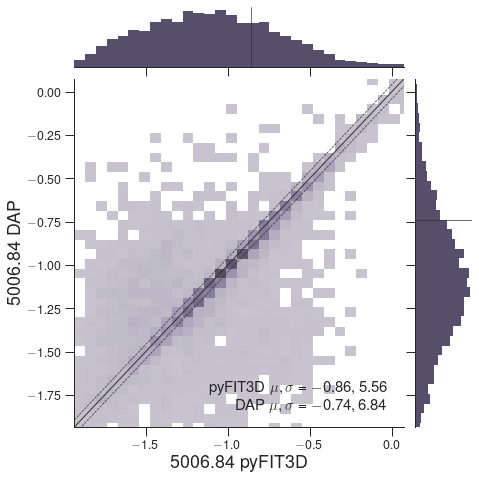

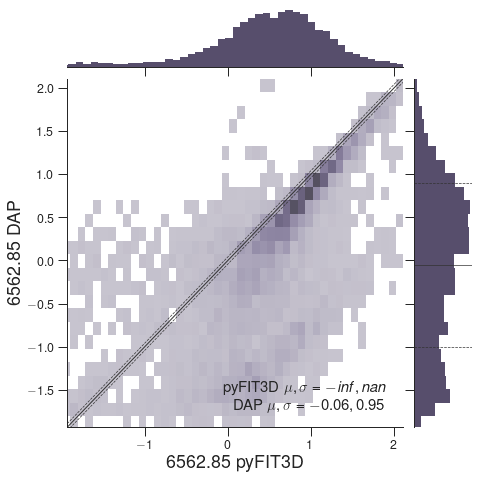

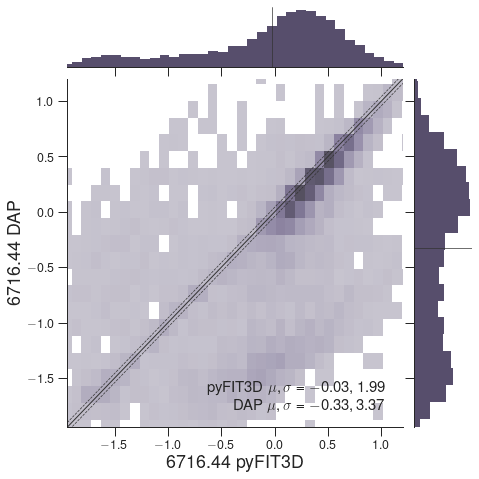

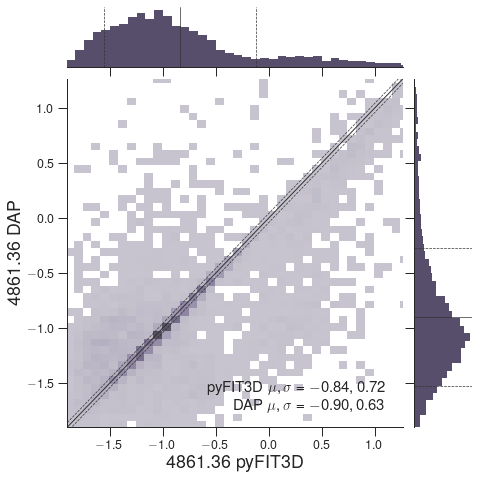

In [14]:
for eline_wl in chosen_elines:
    g = consistency_plot_hist(
        comparison_table=comparison_table,
        column=eline_wl, unit="", is_logscale=True,
        labelx="pyFIT3D", labely="DAP", guide_color="0.2"
    )
    g.fig.savefig(os.path.join(fig_path, f"rsp-{experiment}-{elines_r.get(eline_wl, int(eline_wl))}-consistency.png"), bbox_inches="tight")

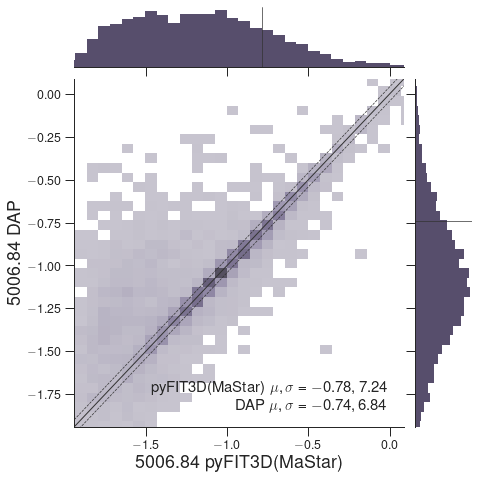

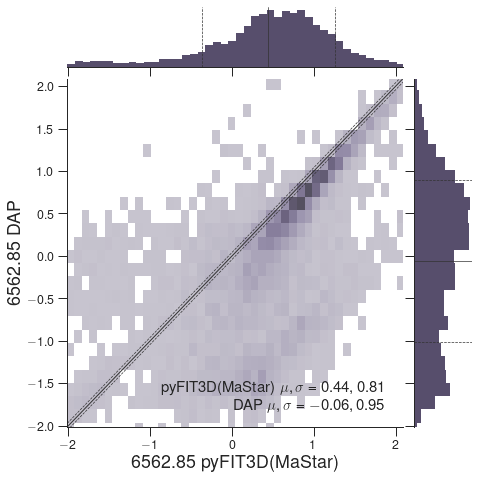

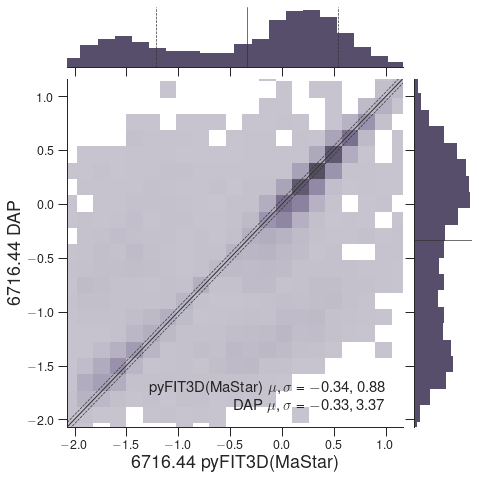

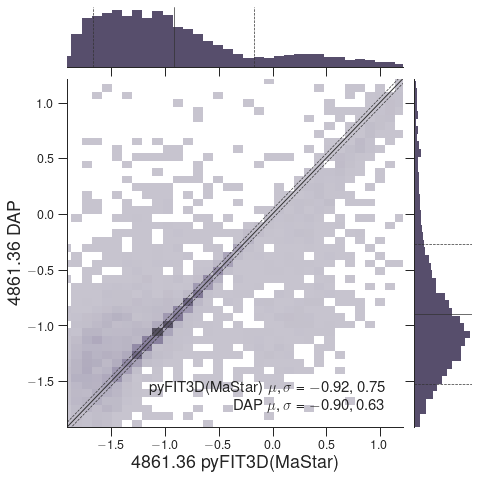

In [15]:
for eline_wl in chosen_elines:
    g = consistency_plot_hist(
        comparison_table=comparison_mastar_table,
        column=eline_wl, unit="", is_logscale=True,
        labelx="pyFIT3D(MaStar)", labely="DAP", guide_color="0.2"
    )
    g.fig.savefig(os.path.join(fig_path, f"rsp-{experiment}-{elines_r.get(eline_wl, int(eline_wl))}-mastar-consistency.png"), bbox_inches="tight")

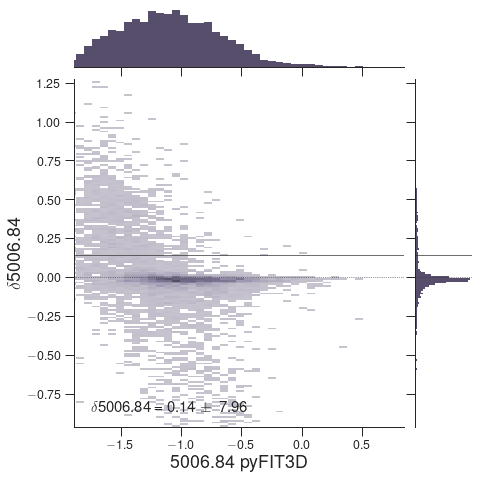

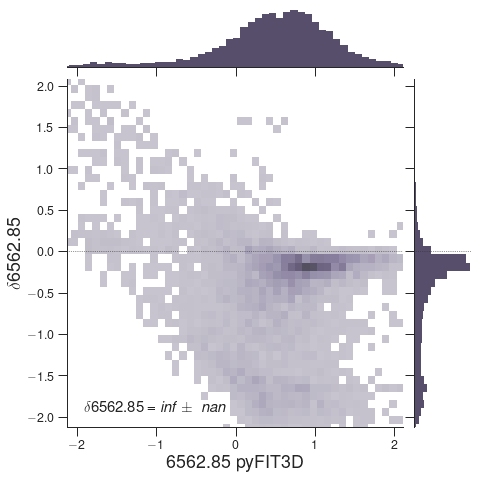

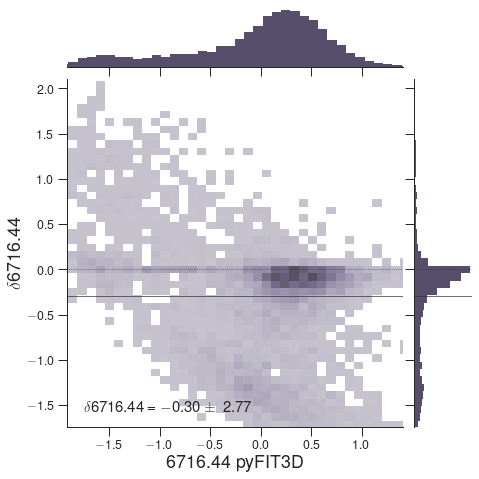

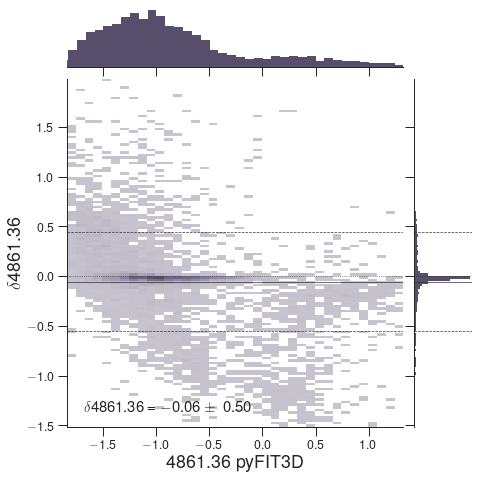

In [16]:
for eline_wl in chosen_elines:
    g = delta_plot(
        comparison_table=comparison_table,
        column=eline_wl, unit="",
        labelx="pyFIT3D", guide_color="0.2"
    )
    g.fig.savefig(os.path.join(fig_path, f"rsp-{experiment}-{elines_r.get(eline_wl, int(eline_wl))}-residuals.png"), bbox_inches="tight")

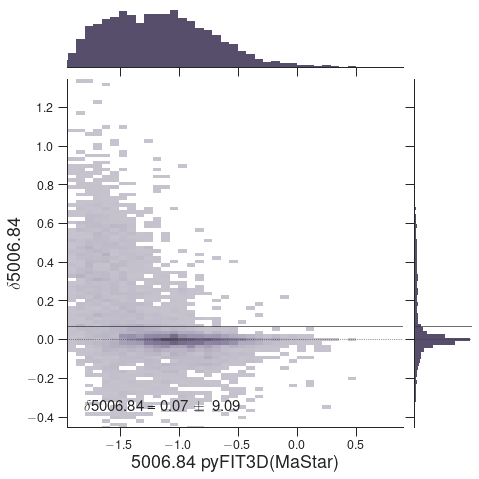

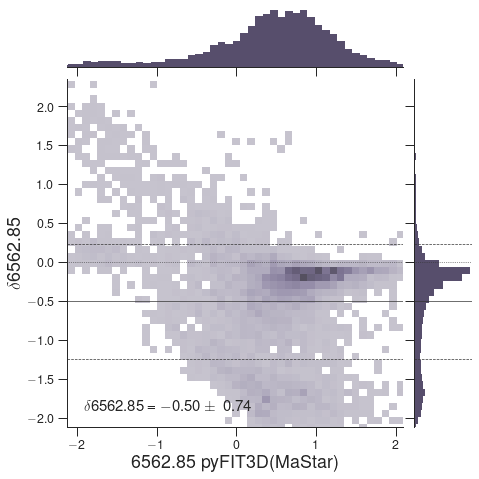

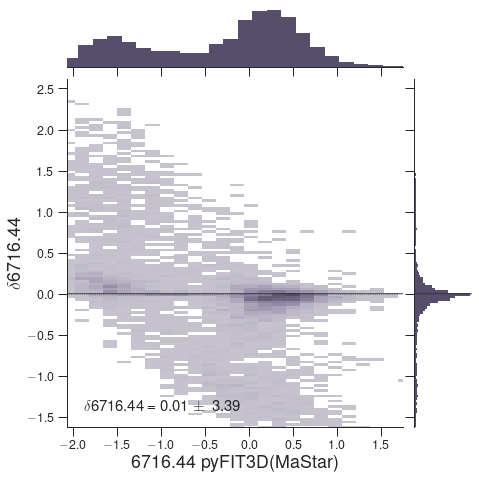

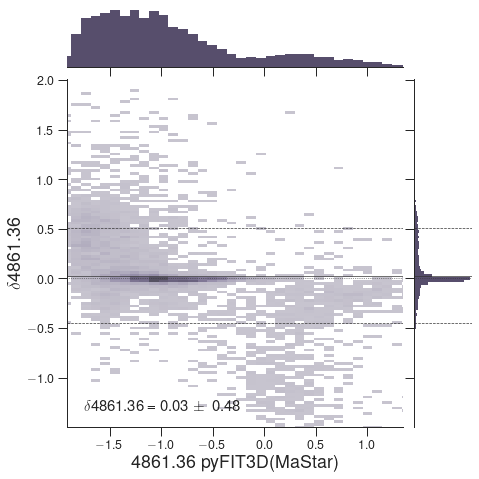

In [17]:
for eline_wl in chosen_elines:
    g = delta_plot(
        comparison_table=comparison_mastar_table,
        column=eline_wl, unit="",
        labelx="pyFIT3D(MaStar)", guide_color="0.2"
    )
    g.fig.savefig(os.path.join(fig_path, f"rsp-{experiment}-{elines_r.get(eline_wl, int(eline_wl))}-mastar-residuals.png"), bbox_inches="tight")

In [118]:
out_fit3d_mastar_path

'/disk-a/mejia/Research/UNAM/lvm-dap/noteboooks/dap-testing/_data/manga/out_fit3d_mastar'

In [111]:
from lvmdap.analysis.stats import weighted_pdf


# TODO: extraer resultados del DAP, especialmente la determinacion del alpha y Fe/H
# HDU of the alpha/Fe vs Fe/H projection
ihdu = 6
feh_means, alpha_means = [], []
age_means, z_means = [], []
skipped = []
for idx, row in tqdm(true_param_table.iterrows(), total=len(true_param_table), desc=f"computing moments", ascii=True, unit="galaxy"):
    label = row.sed_file.replace(".spec_5.txt", "")
    coeffs = pd.read_csv(os.path.join(out_path,f"coeffs_{label}"), sep="\s+")
    coeffs.columns = coeffs.columns[1:].tolist()+["#"]
    coeffs.drop(columns="#", inplace=True)

    coeffs_fit3d = pd.read_csv(os.path.join(out_fit3d_mastar_path,f"coeffs_{label}"), sep="\s+")
    coeffs_fit3d.rename(columns={"#ID": "ID"}, inplace=True)

    if (coeffs.COEFF==0).all() or (coeffs_fit3d.COEFF==0).all():
        skipped.append(label)
        continue
    
    wPDF, x_scale, y_scale = weighted_pdf(stellar_param, ihdu, coeffs=coeffs.COEFF.values)

    xPDF = (wPDF*stellar_param[ihdu].header["CDELT2"]).sum(axis=0)
    xPDF = normalize_to_pdf(xPDF, x_scale)

    yPDF = (wPDF*stellar_param[ihdu].header["CDELT1"]).sum(axis=1)
    yPDF = normalize_to_pdf(yPDF, y_scale)

    # feh_means.append(get_nth_moment(x_scale, xPDF, nth=1))
    # alpha_means.append(get_nth_moment(y_scale, yPDF, nth=1))
    feh_means.append((coeffs.META*(coeffs.COEFF/coeffs.COEFF.sum())).sum())
    alpha_means.append((coeffs.ALPHAM*(coeffs.COEFF/coeffs.COEFF.sum())).sum())

    age_means.append((np.log10(coeffs_fit3d.AGE*1e9)*(coeffs_fit3d.COEFF/coeffs_fit3d.COEFF.sum())).sum())
    z_means.append((np.log10(coeffs_fit3d.MET/0.019)*(coeffs_fit3d.COEFF/coeffs_fit3d.COEFF.sum())).sum())

computing moments: 100%|##########| 10243/10243 [01:35<00:00, 106.92galaxy/s]


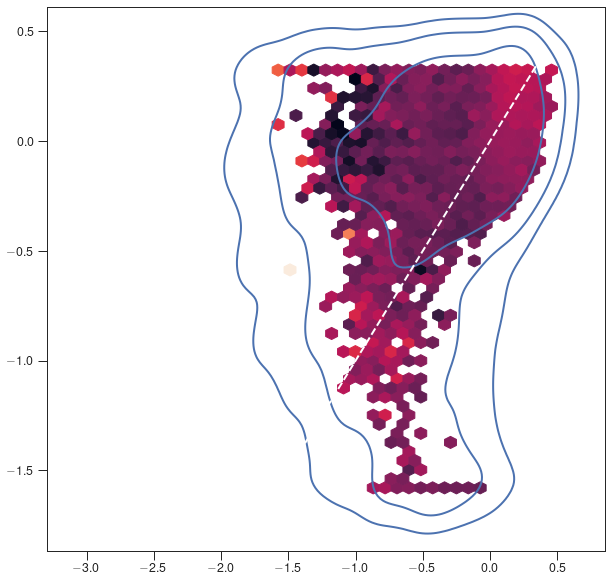

In [157]:
# x = feh_means + 0.75*(alpha_means+feh_means)
x = np.where(feh_means>alpha_means+feh_means, feh_means, alpha_means+feh_means)

plt.hexbin(x, z_means, C=alpha_means, reduce_C_function=np.median, gridsize=40, mincnt=4)
sns.kdeplot(x, z_means, levels=(0.01,0.05,0.32), shade=False)
xx = np.linspace(-1.5, 0.4, 2)
plt.plot(xx, xx, "--", color="w")

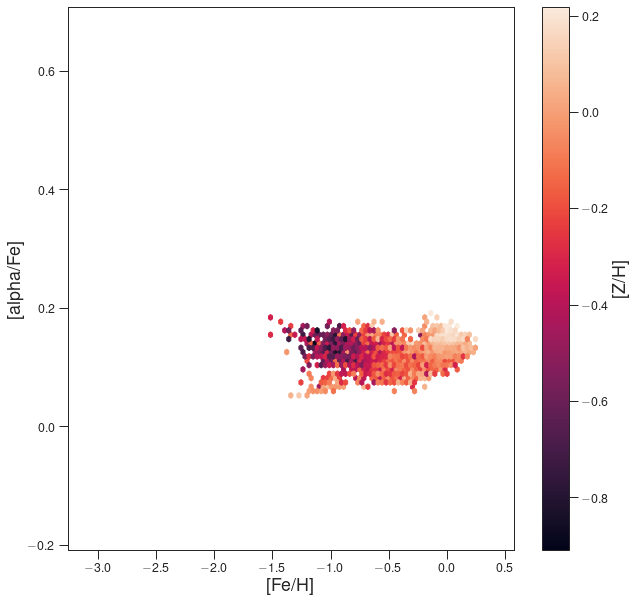

In [112]:
age_means = np.asarray(age_means)
feh_means = np.asarray(feh_means)
alpha_means = np.asarray(alpha_means)
plt.hexbin(feh_means, alpha_means, C=z_means, reduce_C_function=np.mean, mincnt=5)
c = plt.colorbar()
plt.xlabel("[Fe/H]")
plt.ylabel("[alpha/Fe]")
# c.set_label("Age (log/yr)")
c.set_label("[Z/H]")
# plt.xlim(-1.5, 0.0)
# plt.ylim(0.18, 0.3)
# calcular m * alpha/Fe + Fe/H contra Z/H
# colorear con la edad estelar